In [1]:
'''This program reads a dataset AFB.out, containing the cosine of polar angles with respect to the beam-line of 10^4 quark 
    pairs, produced by an electron-positron collider.
    Using this data, applies Bayesian inference to obtain the value of the two free parameters in the expected angular 
    distribution.'''

'This program reads a dataset AFB.out, containing the cosine of polar angles with respect to the beam-line of 10^4 quark \n    pairs, produced by an electron-positron collider.\n    Using this data, applies Bayesian inference to obtain the value of the two free parameters in the expected angular \n    distribution.'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy import stats as st

In [3]:
a=0.95 # Angular acceptance of the detector. The detected cosine of the polar angle (x) can take the values -a <= x <= a
N_MC,NB=10**6,10**4 #Steps in MCMC Metropolis-Hastings algorithm and number of steps in burn-in period

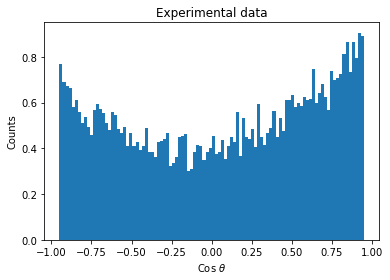

In [4]:
xData = np.loadtxt('AFB.out')
N_events=len(xData)
nbin=100
y,x,dum=plt.hist(xData, nbin, density=True)
plt.xlabel(r'Cos $\theta$')
plt.ylabel('Counts')
plt.title('Experimental data')
plt.savefig("Data.png")

In [5]:
''' Expected distribution for the angular distribution of the experiment. a_fb (forward-backward asymmetry) and beta are 
    the free parameters to be determined, and x corresponds to the cosine of the polar angle.'''
def AngularDist (x, a_fb, beta, a):
    return (1. + 8.*a_fb*x/3. + beta*x**2)/(2.*a*(1. + beta*(a**2)/3.))

In [6]:
'''Generates the logarithm of the likelihood log L(D|a_fb, beta)= sum(log(x|a_fb,beta)) given the values of a_fb, beta and 
    a dataset D = {x}. Imposes the prior conditions a_fb € [-3/8, 3/8] and beta > 0. That is, when these conditions are not 
    fulfilled, the likelihood equals 0.'''
def LogPosterior (a_fb, beta, a):
    if beta > 0 and abs(a_fb) < 3./8.:
        return np.sum(np.log(AngularDist(xData, a_fb, beta, a)))
    else:
        return -np.inf

In [7]:
#sbeta, sa_fb = 1./np.sqrt(N_events), 1./np.sqrt(N_events) # sigma expected for the parameters

sbeta, sa_fb = 0.01, 0.01
'''Given a value of a_fb and beta, samples from a normal distribution, with a mean equal to these values and some expected
    standard deviation. Returns two different values of the parameters.'''
def Proposal_dist (a_fb, beta, sa_fb, sbeta): #Symmetric proposal dist
    y1=np.random.normal(a_fb, sa_fb)
    y2=np.random.normal(beta, sbeta)
    return y1,y2

We will use the Metrplois-Hastings algorithm (a Markov-Chain Monte Carlo method) to sample the posterior PDF, of the parameters given the dataset. 

In [8]:
%%time
'''Markov-Chain Monte Carlo using Metropolis-Hastings algorithm.'''
chain=np.empty((N_MC,3)) # inicialize chain (number values MC, dim problem +1), including Likelihood
# We start at a random point
x1_0,x2_0=0.0,3. #a_fb,beta
chain[0]=x1_0,x2_0,LogPosterior(x1_0,x2_0,a)

for i in range(N_MC-1):
    p1,p2=Proposal_dist(chain[i,0],chain[i,1], sa_fb, sbeta)
    logpost=LogPosterior(p1,p2,a)
    logratio=logpost-chain[i,2] 
    if logratio >= 0: #We are looking for the maximum of the pdf
        chain[i+1]=p1,p2,logpost
    elif logratio > np.log(np.random.random()):
        chain[i+1]=p1,p2,logpost
    else:
        chain[i+1]=chain[i]

Wall time: 1min 30s


In [9]:
chain=chain[NB:]
x1,x2=chain[:,0], chain[:,1]
print('The obtained estimations of the parameters A_fb and beta, corresponding to the sample mean and sample standard deviation '+
      'of the values obtained by the MCMC method are:')
print('A_fb = {:.5f} +- {:.5f}'.format(x1.mean(),x1.std(ddof=1)))
print('Beta = {:.5f} +- {:.5f}'.format(x2.mean(),x2.std(ddof=1)))
print('The correlation coefficient between the two parameters takes the value: r = {:.5f}'.format(np.corrcoef(x1,x2)[0,1]))

The obtained estimations of the parameters A_fb and beta, corresponding to the sample mean and sample standard deviation of the values obtained by the MCMC method are:
A_fb = 0.10217 +- 0.00988
Beta = 1.05266 +- 0.06692
The correlation coefficient between the two parameters takes the value: r = 0.22396


The 2D scatter plot $A_{FB}$ vs. $\beta$ has the form.

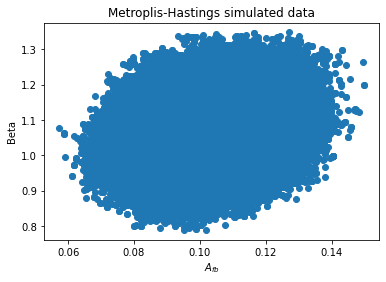

In [10]:
plt.scatter(x1,x2)
plt.xlabel(r'$A_{fb}$')
plt.ylabel('Beta')
plt.title('Metroplis-Hastings simulated data')
plt.savefig("2Dscatter.png")

Plotting the one-dimensional histograms for the variables $A_{FB}$ and $\beta$, one can see that they follow a Gaussian distribution.

In [11]:
'''Given a value x, a mean and a standard deviation, returns the corresponding value of y following a gaussian distribution
   with that mean and standard deviation.'''
def gaussian(x,mean,std):
    return (1./(np.sqrt(2*math.pi)*std))*np.exp(-(x-mean)**2/(2*std**2))

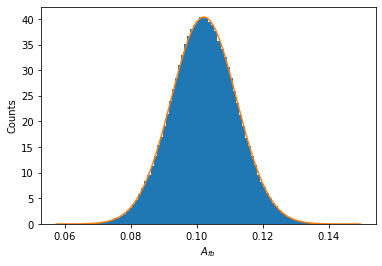

In [12]:
'''Represents the values of the parameter A_fb obtained with the metropolis-hastings algorithm in a histogram. 
    Compares with a Gaussian distribution with a mean and standard deviation equal to the ones of the results of 
    the metropolis-hastings algorithm.'''
values1,bins1,dum1=plt.hist(x1, nbin, density=True)
x=np.linspace(bins1[0],bins1[-1],100)
plt.plot(x, gaussian(x,x1.mean(),x1.std(ddof=1)))
plt.xlabel(r'$A_{fb}$')
plt.ylabel('Counts')
plt.savefig("1Da.png")

The Gaussian distribution fits the histogram for the sampling of the PDF for the parameter $A_{FB}$.

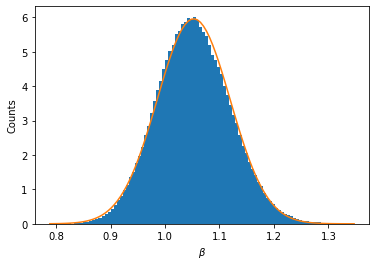

In [13]:
'''Represents the values of the parameter beta obtained with the metropolis-hastings algorithm in a histogram. 
    Compares with a Gaussian distribution with a mean and standard deviation equal to the ones of the results of 
    the metropolis-hastings algorithm.'''
values2,bins2,dum2=plt.hist(x2,nbin,density=True)
x=np.linspace(bins2[0],bins2[-1],100)
plt.plot(x, gaussian(x,x2.mean(),x2.std(ddof=1)))
plt.xlabel(r'$\beta$')
plt.ylabel('Counts')
plt.savefig("1Db.png")

The Gaussian distribution fits the histogram for the sampling of the PDF for the parameter $\beta$.

Now we compute the mode, median and the two 68% CL intervals centered in both values. We will do it using the arrays obtained when plotting the histograms: the limits of the bins and the counts for each bin. Since we generated a normalized histogram, the area below the curve is equal to 1.


In [14]:
# Width of the bins in each histogram
bin_width1 = [bins1[i+1]-bins1[i] for i in range(0,len(bins1)-1)]
bin_width2 = [bins2[i+1]-bins2[i] for i in range(0,len(bins2)-1)]

In [15]:
'''Returns the value of the median and the 68% CL interval around it.'''
def CL(values, bins, width, var):
    if var == 'median':
        cumulative = np.cumsum(values)/np.max(np.cumsum(values))
        index = np.where(cumulative > 0.5)[0][0]
    elif var == "mode":
        index = np.argmax(values)
    else:
        print('This is not a valid type of variable for the central value.')
    
    central_value = (bins[index+1]+bins[index])/2.
    
    print('The value of the {} is: {:.5f} '.format(var,central_value))
    
    CL=values[index]*width[index]
    count=0    
    while CL < 0.68:
        count+=1
        CL += values[index+count]*width[index+count] + values[index-count]*width[index-count]
        
    low_limit = bins[index-1-count]
    up_limit = bins[index + count]
    interval=(low_limit, up_limit)
    
    print('Its 68% CL interval is: ({:.5f}, {:.5f})'.format(low_limit, up_limit))
    
    return central_value, interval

In [16]:
print('For the variable A_fb.')
median1, CL_median1 = CL(values1, bins1, bin_width1, 'median')
mode1, CL_mode1 = CL(values1, bins1, bin_width1, 'mode')
print('\n')
print('For the variable beta.')
median2, CL_median2 = CL(values2, bins2, bin_width2, 'median')
mode2, CL_mode2 = CL(values2, bins2, bin_width2, 'mode')

For the variable A_fb.
The value of the median is: 0.10215 
Its 68% CL interval is: (0.09061, 0.11184)
The value of the mode is: 0.10122 
Its 68% CL interval is: (0.08968, 0.11092)


For the variable beta.
The value of the median is: 1.05394 
Its 68% CL interval is: (0.97850, 1.11820)
The value of the mode is: 1.05394 
Its 68% CL interval is: (0.97850, 1.11820)


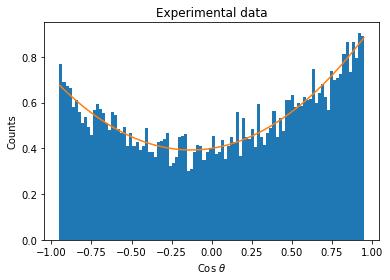

In [17]:
nbin=100
y,x,dum=plt.hist(xData, nbin, density=True)
plt.xlabel(r'Cos $\theta$')
plt.ylabel('Counts')
plt.title('Experimental data')
xs=np.linspace(-0.95,0.95,50)
plt.plot(xs,AngularDist (xs, x1.mean(), x2.mean(), 0.95))
plt.savefig("Data+fit.png")